# Deployment on AWS

In this phase we will deploy our models and data pipeline.

We are going to use Amazon Web Services (AWS), where there are various ways to deploy our project:

- Run an EC2 instance with a web server
- Build a container image and deploy it with Lambda + API Gateway (to manage prediction requests) and ECS + Fargate (for our ETL process)
- Use AWS SageMaker (in this case we would have to rewrite a lot of code)

We are going with Lambda and ECS, because it's faster and cheaper.

Hence we will see how to setup:

- AWS S3, to store trained models.
- AWS Lambda (+ API Gateway), to expose HTTP endpoints to request predictions
- AWS ECS + Fargate, to run the ETL process + training of new models

For starters, we focus on creating a docker image with all the functionalities we need.

Then we are going to setup all configurations for predicting results with Lambda.

To conclude we are going to setup all configurations for ETL and training.

In [1]:
# move to root to simplify imports
%cd ..

C:\Users\marco\PycharmProjects\portfolio-optimization


## Simple Storage Service (S3)

AWS S3 (Simple Storage Service) is a cloud-based object storage service provided by Amazon Web Services (AWS). It allows users to store and retrieve data from anywhere on the internet, using a simple web interface or API calls.

S3 is designed to provide high durability, scalability, and availability for storing and retrieving large amounts of data, ranging from a few kilobytes to multiple terabytes. It offers multiple storage classes to meet different data access needs, including Standard, Infrequent Access (IA), and Glacier.

S3 also provides features such as versioning, encryption, and access control, making it a secure and reliable solution for storing and managing data. It can be used for a variety of use cases, including website hosting, data backup and archiving, content distribution, and big data analytics.

S3 is integrated with other AWS services, such as Amazon EC2, AWS Lambda, AWS Glue, Amazon CloudFront, and Amazon SNS, making it a flexible and powerful solution for building a wide range of cloud-based applications.

We simply create a new **bucket** within AWS S3 dashboard. We will store there our trained models.

https://aws.amazon.com/s3/

## Docker
We will use Docker as our container engine.

A container is portable software that runs in a virtualized environment independent from:
- Platform (cloud, desktop, on premises, ...)
- Operating System (Windows, Linux, MacOS, ...)
- Programming Language (Python, Java, NodeJS, ...)

A Dockerfile is used to build a container image, which is stored in a registry.

The images in our registry can then be used to run containers (an instance of that image).

Let's create a Dockerfile, following AWS documentation.

https://docs.aws.amazon.com/lambda/latest/dg/images-create.html

In [2]:
## DockerFile

#FROM public.ecr.aws/lambda/python:3.7

#COPY requirements.txt .
#RUN pip3 install -r requirements.txt --target "${LAMBDA_TASK_ROOT}"

#COPY . ${LAMBDA_TASK_ROOT}

#CMD ["app.handler"]

The base image *public.ecr.aws/lambda/python:3.7* has a predefined entrypoint that wrap our code an allows it to run inside a lambda handler. This is required when using a container in a Lambda function.

We copy requirements.txt and run pip install to install our dependencies.
**LAMBDA_TASK_ROOT** is an environment variable defined in the AWS image that refers to /var/task, using --target "${LAMBDA_TASK_ROOT}" will install dependencies under /var/task.

We also copy all our project in ${LAMBDA_TASK_ROOT}.

CMD specify the command to be executed by the container. The entrypoint specified by the AWS Lambda base image requires as CMD a function that handles the Lambda function.

In [3]:
def handler(event, context):
    
    # do stuff
    
    return {
                'statusCode': 200,
                'body': "data"
            }

### Upload image to Elastic Container Registry (ECR)
ECR is the AWS Container Registry, where we are going to upload our images.

https://aws.amazon.com/ecr/

Before building the image we create a new repository in AWS ECR.

This will give us a URI similar to [account_id].dkr.ecr.eu-south-1.amazonaws.com/[repository_name].

We can use this to push a container image with the Docker CLI.

First we have to login with AWS CLI credentials. For convenience we created a *portfolio* profile with the AWS CLI to authenticate with our AWS resources.

In [4]:
#aws ecr get-login-password --profile portfolio | docker login --username AWS 
#--password-stdin <account_id>.dkr.ecr.eu-south-1.amazonaws.com

Then we create the image with docker build command, tagging the image with [account_id].dkr.ecr.eu-south-1.amazonaws.com/[repository_name]:[tag].

In [5]:
#docker build -t <account_id>.dkr.ecr.eu-south-1.amazonaws.com/porfolio:version_1 .

Let's push the image to ECR.

In [6]:
#git push <account_id>.dkr.ecr.eu-south-1.amazonaws.com/porfolio:version_1

Every time we push a new image, AWS creates automatically a sha identifier associated with the container for versioning purposes.

Now we can use the image saved under [account_id].dkr.ecr.eu-south-1.amazonaws.com/porfolio:version_1 with AWS resources like Lambda and ECS.

## AWS Lambda

AWS Lambda is a serverless compute service provided by Amazon Web Services (AWS). It allows us to run our code in the cloud without managing servers, operating systems, or infrastructure.

https://aws.amazon.com/lambda/

### Setup Lambda

To setup a Lambda function to act as a serverless predictor we a Lambda using our container image.
Selecting *Create function* from AWS Lambda dashboard we can choose *Container image* as configuration option. 

Here we can choose the *function name*, we choose **predict** and specify a *Container image URI*.

With the new Lambda function created we need to add an **API Gateway** as trigger of the function. This allows us to send request to a specified endpoint that will call the Lambda handler method as specify in the CMD line of the Dockerfile of our image.

Once set the API Gateway we will have an endpoint similar to: https://[api_gateway_id].execute-api.eu-south-1.amazonaws.com/default/predict.

We can use this URL in a simple HTTP request to get the predicted values.

### Predict with Lambda

To predict with lambda we need to define the app.handler method, inside the app.py file.

This handler method will take *event* and *context* as input parameters and then call a predict method.

In [7]:
# app.py

def handler(event, context):
    """
    :param event: event parameters passed by Lambda handler
    :param context: context parameters passed by Lambda handler
    :return: json that Lambda will wrap as body of an HTTP response
    
    Note that request will have this body:
    event['body'] : {
        "model":["HYBRID" | "LINEAR" | "ARIMA" ],  the model we want to use for prediction
        "target": targetXXX, # the target we want to predict
        "start_date": YYYY-MM-DD, the start date of the predicition
        "end_date": YYYY-MM-DD, the end date of the prediction
    }
    """

    try:
        d = json.loads(event['body'])

        if d is not None:
            r = predict(d["model"], d["target"], \
                        start_date=pd.Timestamp(d["start_date"]), end_date=pd.Timestamp(d["end_date"]))
            
            return {
                'statusCode': 200,
                'body': json.dumps(r)
            }
        
    except Exception as e:
        error = e

    return {
        'statusCode': 400,
        'body': e
    }

The handler reads the event parameter and call the predict method passing the chosen model, target and dates.

For this example, as we said in Modeling we use the hybrid model with exogenous features.

In [8]:
# This predict method takes the input parameters, 
# load the trained model stored on S3 and then predict values on specified dates.

from portfolio_optimization.db import get_df_from_table
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.deterministic import DeterministicProcess
import pickle
from portfolio_optimization.data_lake.s3_sandbox import get_object_from_s3

from configparser import ConfigParser
parser = ConfigParser()
_ = parser.read("credentials.cfg")
BUCKET_ID = parser.get("s3", "BUCKET_ID")

def standardize_features(df):
    scaled_features = StandardScaler().fit_transform(df.values)
    return pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

def apply_pca(df, pca_components):
    idx = df.index
    cols = [f"featurePCA{i + 1}" for i in range(pca_components)]

    df = PCA(n_components=pca_components).fit_transform(df)
    df = pd.DataFrame(df, columns=cols)
    df.index = idx
    return df

def get_X(df, cols):
    X = df[cols].dropna()
    X = standardize_features(X)
    pca_components = int(len(cols)/2)
    X = apply_pca(X, pca_components)
    return X

def make_lags(df, lags):
    res = df.copy()
    old_cols = df.columns
    for i in range(1, lags + 1):
        for col in old_cols:
            res[f"{col}_lag_{i}"] = res[col].shift(i)
    return res.drop(old_cols, axis=1)

def predict(model_name, target, start_date, end_date):
    """
    :param model_name: model name
    :param target: target name
    :param start_date: start date of the prediction
    :param end_date: end date of the prediction
    :return:
    """
    
    df = get_df_from_table("pivot")
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values(by="date").set_index("date").apply(pd.to_numeric).asfreq('MS')
    feature_columns = [col for col in df.columns if 'feature' in col]
    
    if model_name == 'HYBRID':
        
        y = df[[target]].dropna()
        X = get_X(df, feature_columns)

        y, X = y.align(X, join="inner", axis=0)
        
        dp = DeterministicProcess(
            index=y.index,
            constant=True,
            order=2,
            drop=True,
            seasonal=False,
        )
        X_dp = dp.in_sample()

        lags = 1

        X_lags = make_lags(y, lags=lags)
        X_lags = pd.concat([X_lags, make_lags(X, lags=lags)], axis=1)
        X_lags = X_lags.fillna(0.0)

        X_dp = X_dp[(X_dp.index >= start_date) & (X_dp.index <= end_date)]
        X_lags = X_lags[(X_lags.index >= start_date) & (X_lags.index <= end_date)]

        model_trend_season = pickle.loads(get_object_from_s3(f"hybrid_trend_estimator-{target}", BUCKET_ID))
        
        y_hat = pd.DataFrame(model_trend_season.predict(X_dp), index=X_dp.index, columns=[target]) 

        model_cycle = pickle.loads(get_object_from_s3(f"hybrid_cycle_estimator-{target}", BUCKET_ID))

        y_hat += pd.DataFrame(model_cycle.predict(X_lags), index=X_lags.index, columns=[target]) 
        
        return y_hat
    
predict("HYBRID", "target266", "2020-01-01", "2020-08-01")

,target266
date,
2020-01-01,1565.911045
2020-02-01,1571.569435
2020-03-01,1597.882880
2020-04-01,1685.889145
2020-05-01,1716.571334
2020-06-01,1789.491161
2020-07-01,1964.725304
2020-08-01,1950.162116


Now that are Lambda is ready, we need to deploy our ETL + Training to AWS in order to train our models, so that we can use them with Lambda to serve predictions.

## Elastic Container Service (ECS)

AWS Elastic Container Service (ECS) is a fully-managed container orchestration service provided by Amazon Web Services. It allows users to easily run and scale containerized applications in the cloud using Docker containers.

With ECS, users can create and manage clusters of EC2 instances, which can then be used to deploy and run containerized applications. Users can define and configure their containerized applications using task definitions, which specify the Docker image, container port mappings, and other settings required to run the application.

ECS also includes a service scheduler that allows users to easily deploy, manage, and scale their applications across multiple instances. The service scheduler monitors the health of instances and containers and automatically replaces failed instances or containers to maintain availability and reliability.

https://aws.amazon.com/ecs/

### AWS Fargate
We will use AWS Fargate to deploy our container.

AWS Fargate is a serverless compute engine provided by Amazon Web Services (AWS) for running containers. It allows users to run Docker containers without the need to manage the underlying infrastructure, including servers, operating systems, or clusters.

This solution is ideal to because it allows execution of long running task (like data collection, ETL, model training, ...).

https://aws.amazon.com/fargate/

### ECS setup

First we need to create an **ECS cluster**, *ecs_portolio_cluster*. 

An Amazon ECS cluster groups together tasks, and services, and allows for shared capacity and common configurations. All of your tasks, services, and capacity must belong to a cluster.

Then we create a new **task definition**, *portfolio_etl_training*.

A task definition is required to run Docker containers in Amazon ECS. When creating a task definition we can specify the URI of our container, we are going to use the same image we are using for Lambda: [account_id].dkr.ecr.eu-south-1.amazonaws.com/porfolio:version_1.

Then we can specify a new *ENTRYPOINT* to execute a different command on the container. The new entry point is: *python,aws_fargate.py*, that call the aws_fargate.py file containing the code to execute for ETL to update our data and then call the training method to train our models and store them on the S3 bucket.

In [9]:
def training():
    
    # Get data from pivot table and transform them to be ready for modeling.
    feature_columns, target_columns, df = get_df(stationary=True, mode="diff")

    # For each target, train a new model and store its pickle serialization to S3
    for t_col in target_columns:
        
        X = get_X(df, feature_columns)
        y = df[[target]].dropna()
        y, X = y.align(X, join="inner", axis=0)

        dp = DeterministicProcess(
            index=y.index,
            constant=True,
            order=2,
            drop=True,
            seasonal=False,
        )
        X_dp = dp.in_sample()

        X_lags = make_lags(y, lags=lags)
        X_lags = pd.concat([X_lags, make_lags(X, lags=lags)], axis=1)
        X_lags = X_lags.fillna(0.0)    

        model = LinearRegression()
        model.fit(X_dp, y)

        # model.pushs3
        put_object_to_s3(pickle.dumps(model), BUCKET_ID, f"hybrid_trend_estimator-{target}")

        y_hat = pd.DataFrame(model.predict(X_dp), index=y.index, columns=y.columns) 
        y -= y_hat

        model = GradientBoostingRegressor()
        model.fit(X_lags, y.values.ravel())

        # model.pushs3
        put_object_to_s3(pickle.dumps(model), BUCKET_ID, f"hybrid_cycle_estimator-{target}")
        
        
def aws_fargate():
    # donwload data from sources: FRED, Yahoo Finance, Investing.com and OECD
    extract()
    
    # Clean and trasform data then load them into pivot table on PostgresSQL
    transform_and_load()
    
    # train our models with the new training data and save them into S3
    training()

This task can be manually executed from ECS dashboard or can be scheduled to repeat periodically.

Now that we have our data pipeline and prediction endpoint in place let's use it to do some prediction.

In [10]:
# requests.get => prediction
import requests
import pandas as pd
from configparser import ConfigParser
from portfolio_optimization.db import get_df_from_table

parser = ConfigParser()
_ = parser.read("credentials.cfg")
url = parser.get("lambda", "api_gateway_url")

target = "target266"
r = requests.post(url, json={"model":"HYBRID", "target":target,\
                    "start_date":"2020-01-01", "end_date":"2020-08-01"})

df = pd.DataFrame(r.json())
df.columns = ["date",target]
df["date"] = pd.to_datetime(df["date"])
df[target] = pd.to_numeric(df[target])
df = df.set_index("date")
df

,target266
date,
2020-01-01,1724.202872
2020-02-01,1776.957791
2020-03-01,1788.702834
2020-04-01,1698.771259
2020-05-01,1748.289117
2020-06-01,1939.193156
2020-07-01,1957.580791
2020-08-01,1894.780745


Let's plot the prediction against actual values.

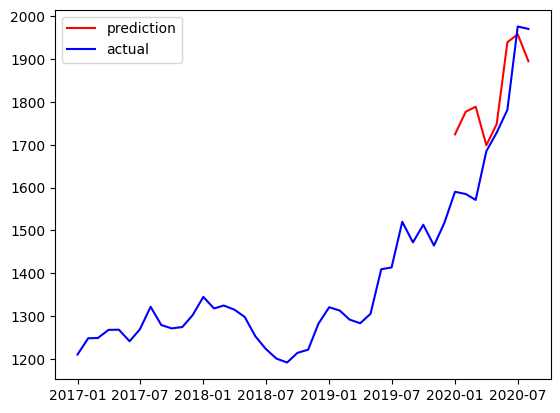

In [11]:
import matplotlib.pyplot as plt

# plot actual + predictions
df_actual = get_df_from_table("pivot")
df_actual["date"] = pd.to_datetime(df_actual["date"])
df_actual = df_actual.sort_values(by="date").set_index("date")\
    .apply(pd.to_numeric).asfreq('MS')[[target]]

df_actual = df_actual.rename({target:f"{target}_actual"}, axis=1)
df_actual = df_actual[(df_actual.index >= pd.Timestamp('2017-01-01'))\
                      & (df_actual.index <= pd.Timestamp('2020-08-01'))]

df_join = pd.merge(df, df_actual, how="right", left_index=True, right_index=True)
plt.plot(df_join.index, df_join[target], color="red", label="prediction")
plt.plot(df_join.index, df_join[f"{target}_actual"], color="blue", label="actual")
plt.legend()

plt.show()

## Project conclusion
We started our journey with this question in mind.

**Problem**: Is it possible to use macroeconomic data to "predict" an optimal asset allocation for a portfolio to achieve better risk-adjusted returns?

To answer this we have tried different modeling techniques, but we have seen that the prediction accuracy is not extraordinary.
We had assumed, at the beginning, that the "main" feature predictors would have been the exogenous features, but we found out that the target past values (aka endogenous features) also help the model accuracy by far.

What kind of returns can we expect by using our model to perform portfolio asset allocation?

Let's find out for an example period (2010-2020).

We use these targets both as target for our model and benchmark for our portfolio.
- Equity: SP500, target259
- Real Estate: HousingPrices OECD, target267
- Commodity: Gold, target266
- Bonds: 10Y Treasury, target256
- Cash: 3Mo bill, target71

In [12]:
def position_by_returns(data):
    '''
    For this example we want only long position.
    
    data contains expected returns for each of our targets.
    to compute portfolio position (in percent terms) we divide each 
    target expected return by the sum of the POSITIVE expected returns.
    
    We ignore negative expected returns as it would involve short positions.
    
    example
    data = {"t1": 0.3, "t2": 0.2, "t3": -0.1}
    sum of positive returns = 0.5
    result = {"t1": 0.6, "t2": 0.4, "t3": 0}
    '''

    
    result = {}
    sum_returns = 0
    
    for k, v in data.items():
        if v > 0:
            sum_returns += v
    
    for k, v in data.items():
        if v > 0:
            result[k] = v / sum_returns
        else:
            result[k] = 0

    return result

def get_current_price(df, column, year):
    '''
    get the df[column] price on the last date of the specified year.
    '''
    
    return df.loc[pd.Timestamp(f"{year}-12-01"), column]

def get_pivot_df():
    '''
    get df from postgreSQL table "pivot"
    '''
    df = get_df_from_table("pivot")
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values(by="date").set_index("date")\
        .apply(pd.to_numeric).asfreq('MS')
    return df

def get_prediction_df(url, json):
    r = requests.post(url, json=json)
        
    df = pd.DataFrame(r.json())
    df.columns = ["date",json["target"]]
    df["date"] = pd.to_datetime(df["date"])
    df[json["target"]] = pd.to_numeric(df[json["target"]])
    df = df.set_index("date")
    
    return df

def compute_portfolio_value(portfolio, returns, year):
    '''
    compute portfolio mark-to-market value by multiplying the assets
    contained in the portfolio for their respective current market prices
    
    cash price is = 1 + short-term interest rate
    bond price is computed from the long-term interest rate
    assuming 10y maturity, zero-coupon and face value = 1000
    '''
    
    portfolio_value = 0
                    
    for k, v in portfolio.items():

        # for cash
        if k == "target71":
            price = 1 + returns[k]

        else:
            price = get_current_price(df, k, year)

            # for bond
            if k == "target256":
                price = 1000 / pow(1 + price/100, 10)  

        portfolio_value += v * price
        
    return portfolio_value

def compute_return(pred_df, target, initial_value):
    '''
    compute the returns as a simple ROI calculation based on 
    final value and initial value.
    
    cash return is the average yield of short-term 3Mo bills.
    bond price is computed from the long-term interest rate
    assuming 10y maturity, zero-coupon and face value = 1000
    '''
    
    final_value = pred_df.iloc[-1, 0]

    # for cash
    if target == "target71":
        return (final_value + initial_value) / 2

    else:

        # for bond
        if target == "target256":
            initial_value = 1000 / pow(1 + initial_value/100, 10)
            final_value = 1000 / pow(1 + final_value/100, 10)

        return final_value / initial_value - 1
    
def allocate_portfolio_current(allocation, df, year, portfolio_value):
    '''
    calculate asset quantity to allocate in the portfolio based on 
    their current price.
    
    We have only long positions, so the computation is fairly easy.
    '''
    
    portfolio_current_value = 0
    
    for k, v in allocation.items():
        
        # keep only long positions
        if v > 0:
        
            # for cash
            if k == "target71":
                price = 1

            else:
                price = get_current_price(df, k, year)

                # for bond
                if k == "target256":
                    price = 1000 / pow(1 + price/100, 10)

            portfolio_current[k] = portfolio_value * v / price
            portfolio_current_value += portfolio_value * v
            
            
            # print(k, v, price, portfolio_value * v / price)
            
        else:
            
            portfolio_current[k] = 0
    
    return portfolio_current

In [13]:
target_list = ["target259","target267","target266","target256","target71"]
model = "HYBRID"

# Beginning year for simulation
start_year = 2010
simulation_years = 10

all_predictions_df = None

# get all predictions
for t in target_list:
    
    if all_predictions_df is None:
        all_predictions_df = get_prediction_df(url, {"model":model, "target":t,\
                "start_date":f"{start_year}-01-01", "end_date":f"{start_year+simulation_years}-12-01"})
    
    else:
        all_predictions_df = pd.merge(all_predictions_df, get_prediction_df(url, {"model":model, "target":t,\
                "start_date":f"{start_year}-01-01", "end_date":f"{start_year+simulation_years}-12-01"}), how="inner",\
                                     left_index=True, right_index=True)

In [14]:
all_predictions_df.tail()

,target259,target267,target266,target256,target71
date,,,,,
2020-08-01,3489.212167,138.002709,1894.780745,0.686600,0.000594
2020-09-01,3502.879483,140.808268,1889.041172,0.965043,0.001490
2020-10-01,3562.780258,141.637440,1816.573519,1.016956,0.001678
2020-11-01,3693.852284,142.611994,1874.192887,1.027658,0.001538
2020-12-01,3716.528313,143.642390,1817.990520,0.999666,0.000364


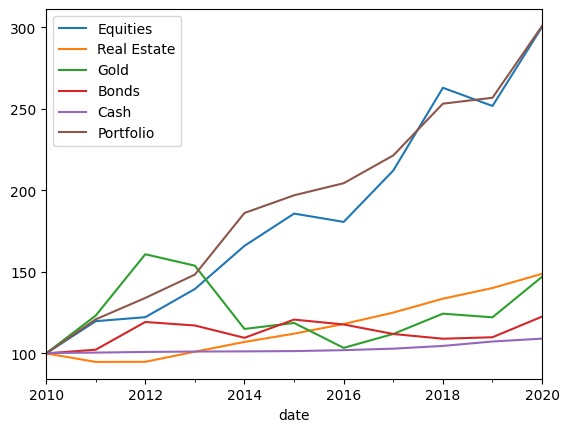

In [15]:
import datetime

portfolio_start_value = 100
portfolio_value = 0
portfolio_history = []
portfolio_current = {}

# get pivot from postgreSQL
df = get_pivot_df()[target_list]

for i in range(simulation_years):
    
    # print(f"STEP {i+1}")
    
    start_date = f"{start_year + i}-01-01"
    end_date = f"{start_year + i}-12-01"
       
    if i == 0:
        portfolio_value = portfolio_start_value
        
    else:
        # get current portfolio value
        portfolio_value = compute_portfolio_value(portfolio_current, \
                                                  returns, start_year+i-1)
            
    portfolio_history.append({"date": datetime.date(start_year+i,1,1), \
                      "Portfolio":portfolio_value})
    
    returns = {}
    
    for t in target_list:
        
        # get prediction for the target in the current period
        pred_df = all_predictions_df.copy()[[t]]
        
        pred_df = pred_df[(pred_df.index >= pd.Timestamp(start_date)) & \
                          (pred_df.index <= pd.Timestamp(end_date))]
        
        initial_value = df.loc[pd.Timestamp(start_date), t]
        
        # calculate asset return
        returns[t] = compute_return(pred_df, t, initial_value)        
    
    # calculate asset % allocation based on their returns
    allocation = position_by_returns(returns)
    # print("ALLOCATION", allocation)
    
    # calculate asset quantity allocation based on their price
    portfolio_current = allocate_portfolio_current(allocation, df,\
                                                   start_year+i-1, portfolio_value)
    # print("PORTFOLIO", portfolio_current)

# Compute final portfolio value
portfolio_value = compute_portfolio_value(portfolio_current, \
                                                  returns, start_year+i)
portfolio_history.append({"date": datetime.date(start_year+i+1,1,1), \
                      "Portfolio":portfolio_value})
    
portfolio_df = pd.DataFrame(portfolio_history)
portfolio_df["date"] = pd.to_datetime(portfolio_df["date"])

# join to have our portfolio and benchmark values in the same df
portfolio_df = pd.merge(df, portfolio_df, \
                        how="inner", left_index=True, right_on="date")
portfolio_df = portfolio_df.set_index("date")

# Transform bond yield to bond price
portfolio_df["target256"] = portfolio_df["target256"]\
    .apply(lambda x:1000 / pow(1 + x/100, 10))

# Cash
portfolio_df["target71"] += 1
    
legend_names = {"target259":"Equities","target267":"Real Estate",\
               "target266":"Gold", "target256":"Bonds", "target71":"Cash"}

for t in target_list:
    
    # Cash, the cumulative return is the cumulate product of the returns
    if t == "target71":
        portfolio_df[t] = portfolio_df[t].cumprod() \
        * portfolio_start_value
        
    else:
        portfolio_df[t] = portfolio_df[t] \
        / portfolio_df[t].iloc[0] * portfolio_start_value
    
portfolio_df = portfolio_df.rename(legend_names, axis=1)
           
portfolio_df.plot()
plt.legend()
plt.show()

The result we get is really not bad, despite the "not so great" performance metrics of the model.

However, we have to keep into consideration that the model we are using to predict has been trained on the same data (exogenous features) that we are now using as features to predict.

Having said that, we cannot assume that future predictions would assure results similar to the ones showed here in this last example.

### Further implementations
Possible improvements to our project:
- collect and use more and different features (more granular)
- try different regression models (including Neural Networks) and perform hyper-parameter optimization
- achieve stationarity by using some computation based on inflation (instead of differencing) 
- normalize data taking into account black swan events like 2008-crisis or 2020-Covid